In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
import argparse
import numpy as np
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import os
import json
from functools import partial
import sys
from tqdm import tqdm


from tianshou.utils import WandbLogger
from tianshou.data import Batch, Collector, ReplayBuffer, VectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.policy import BasePolicy, PPOPolicy
from tianshou.trainer import OnpolicyTrainer
from tianshou.utils.net.common import ActorCritic, Net
#from tianshou.utils.net.discrete import Actor, Critic
from tianshou.utils.net.continuous import Actor, Critic, ActorProb

import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import TimeLimit, RescaleAction, TransformObservation
from stable_baselines3.common.env_checker import check_env

from lib.environments import get_environment
from lib.environments.kolmogorov import KolmogorovEnvironment
from lib.policy import get_rl_algo
from lib.distributions import ElementwiseNormal
from lib.models import get_actor_critic
from lib.utils import str2bool, Config, dict_to_wandb_table, restrict_to_num_threads
from lib.trainer import MyOnpolicyTrainer

#temporary solution for xlb imports
sys.path.append(os.path.abspath('/home/pfischer/XLB'))
#from my_flows.kolmogorov_2d import Kolmogorov_flow
from my_flows.helpers import get_kwargs

import wandb
wandb.require("core")

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def get_args() -> argparse.Namespace:
    parser = argparse.ArgumentParser()
    parser.add_argument("--task", type=str, default="CartPole-v1")
    parser.add_argument("--model", type=str, default="ppo")
    parser.add_argument("--reward_threshold", type=int, default=500)
    parser.add_argument("--seed", type=int, default=42)
    parser.add_argument("--buffer_size", type=int, default=5000)
    parser.add_argument("--max_epoch", type=int, default=20)
    parser.add_argument("--step_per_epoch", type=int, default=1000)
    parser.add_argument("--train_num", type=int, default=1)
    parser.add_argument("--test_num", type=int, default=1)
    parser.add_argument("--logdir", type=str, default="log")
    parser.add_argument("--gamma", type=float, default=0.97)
    parser.add_argument("--lr", help='learning rate', type=float, default=0.0003)
    parser.add_argument("--repeat_per_collect", type=int, default=10)
    parser.add_argument("--episode_per_test", type=int, default=1)
    parser.add_argument("--batch_size", type=int, default=32)
    parser.add_argument("--step_per_collect", type=int, default=100) 
    parser.add_argument("--architecture", type=int, default=[64, 64])
    parser.add_argument("--backbone_out_dim", type=int, default=64)

    return parser.parse_known_args()[0]


def create_env(kwargs1, kwargs2, max_t=50000, min_a=-1., max_a=1.):
    """
    creates the environemnt and applyes wrappers to action and
    observations space and sets time limit.
    """
    env = KolmogorovEnvironment(kwargs1, kwargs2)
    env = TimeLimit(env, max_episode_steps=max_t)
    env = RescaleAction(env, min_action=min_a, max_action=max_a)
    env = TransformObservation(env, lambda obs: (obs/20))
    return env


class Backbone(nn.Module):

    def __init__(self, out_size=64, device="cpu"):
        super(Backbone, self).__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 2, 3, stride=2, padding=1),
            nn.BatchNorm2d(2),
            nn.ReLU(True),
            nn.Conv2d(2, 4, 3, stride=2, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            nn.Conv2d(4, 8, 3, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.MaxPool2d(2,2)
        )
        
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(True),
            #nn.Dropout(p=0.5),
            nn.Linear(128, out_size),
            nn.ReLU(True),
        )
        
    #def forward(self, x):
    #    x = x.reshape(x.shape[0],1,128,128)
    #    x = self.encoder_cnn(x)
    #    x = x.reshape(x.shape[0], -1)
    #    x = self.encoder_lin(x)
    #    return x

    def forward(self, obs, state=None, info={}):
        if not isinstance(obs, torch.Tensor):
            obs = torch.tensor(obs, dtype=torch.float, device=device)
        batch = obs.shape[0]

        obs = self.encoder_cnn(obs.reshape(batch, 1, 128, 128))
        obs = obs.reshape(batch, -1)
        logits = self.encoder_lin(obs)

        return logits, state

In [4]:
#######################################################################################################
####### setup stuff *##################################################################################
#######################################################################################################
args = get_args()
# seed
np.random.seed(args.seed)
torch.manual_seed(args.seed)

#restrict_to_num_threads(1)

In [5]:
#######################################################################################################
####### environments ##################################################################################
#######################################################################################################
u0_path = "/home/pfischer/XLB/vel_init/velocity_burn_in_1806594.npy" #4096x4096 simulation
rho0_path = "/home/pfischer/XLB/vel_init/density_burn_in_1806594.npy" #4096x4096 simulation
kwargs1, T1,_,_ = get_kwargs(u0_path=u0_path, rho0_path=rho0_path, lamb=1) #cgs 
kwargs2, T2,_,_ = get_kwargs(u0_path=u0_path, rho0_path=rho0_path, lamb=1) #fgs
#check if cgs time is a factor of fgs time
assert (T2%T1 == 0)
env = create_env(kwargs1, kwargs2, max_t=T1)
train_env = DummyVectorEnv([lambda: create_env(kwargs1, kwargs2, max_t=T1) for _ in range(args.train_num)])
test_env = DummyVectorEnv([lambda: create_env(kwargs1, kwargs2, max_t=T1) for _ in range(args.test_num)])

m_prime = 31232.0, end time = 31232 steps, T=355, io_rate = 64.0, Number of outputs = 490.0
m_prime = 31232.0, end time = 31232 steps, T=355, io_rate = 64.0, Number of outputs = 490.0


In [6]:
print(env.observation_space.shape)
print(env.action_space.shape)

(128, 128)
(1,)


In [7]:
#Policy
assert env.observation_space.shape is not None  # for mypy
assert env.action_space.shape is not None

#net = Net(state_shape=env.observation_space.shape, hidden_sizes=args.architecture, device=device).to(device)
net = Backbone(out_size=args.backbone_out_dim, device=device).to(device)
#net = Net1(state_shape=env.observation_space.shape, action_shape=(64,)).to(device)
actor = ActorProb(preprocess_net=net, action_shape=env.action_space.shape, max_action=1,
                 preprocess_net_output_dim=args.backbone_out_dim, device=device).to(device)
critic = Critic(preprocess_net=net, preprocess_net_output_dim=args.backbone_out_dim, device=device).to(device)
actor_critic = ActorCritic(actor=actor, critic=critic)
optim = torch.optim.Adam(actor_critic.parameters(), lr=args.lr)
dist = torch.distributions.Normal
policy = PPOPolicy(
    actor=actor,
    critic=critic,
    optim=optim,
    dist_fn=dist,
    action_space=env.action_space,
    deterministic_eval=True,
    action_scaling=False,
)

In [8]:
#Collectors
train_collector = Collector(
    policy=policy,
    env=train_env,
    buffer=VectorReplayBuffer(args.buffer_size, len(train_env)),
)
test_collector = Collector(policy=policy, env=test_env)
train_collector.reset()
test_collector.reset()

In [9]:
 #Trainer
trainer = OnpolicyTrainer(
    policy=policy,
    train_collector=train_collector,
    test_collector=test_collector,
    max_epoch=args.max_epoch,
    step_per_epoch=args.step_per_epoch,
    repeat_per_collect=args.repeat_per_collect,             
    episode_per_test=args.episode_per_test,
    batch_size=args.batch_size,
    step_per_collect=args.step_per_collect,
    #stop_fn=lambda mean_reward: mean_reward >= args.reward_threshold,
    #save_checkpoint_fn=checkpoint_fn,
    #logger=logger,
)

In [10]:
result = trainer.run()

Epoch #1: 1001it [00:10, 95.69it/s, env_step=1000, len=92, loss=38.618, loss/clip=-0.004, loss/ent=1.437, loss/vf=77.273, n/ep=0, n/st=100, rew=91.48]                          


Epoch #1: test_reward: 3057.613368 ± 0.000000, best_reward: 6877.294520 ± 0.000000 in #0


Epoch #2: 1001it [00:09, 101.53it/s, env_step=2000, len=118, loss=106.716, loss/clip=-0.005, loss/ent=1.465, loss/vf=213.470, n/ep=0, n/st=100, rew=117.38]                         


Epoch #2: test_reward: 1536.911285 ± 0.000000, best_reward: 6877.294520 ± 0.000000 in #0


Epoch #3: 1001it [00:05, 189.56it/s, env_step=3000, len=118, loss=0.668, loss/clip=-0.006, loss/ent=1.452, loss/vf=1.376, n/ep=0, n/st=100, rew=117.38]                            


Epoch #3: test_reward: 4613.885747 ± 0.000000, best_reward: 6877.294520 ± 0.000000 in #0


Epoch #4: 1001it [00:07, 138.00it/s, env_step=4000, len=1304, loss=0.152, loss/clip=-0.007, loss/ent=1.430, loss/vf=0.346, n/ep=0, n/st=100, rew=1286.51]                            


Epoch #4: test_reward: 1246.066429 ± 0.000000, best_reward: 6877.294520 ± 0.000000 in #0


Epoch #5: 1001it [00:08, 122.43it/s, env_step=5000, len=994, loss=0.296, loss/clip=-0.002, loss/ent=1.447, loss/vf=0.625, n/ep=0, n/st=100, rew=980.59]                            


Epoch #5: test_reward: 1318.068661 ± 0.000000, best_reward: 6877.294520 ± 0.000000 in #0


Epoch #6: 1001it [00:07, 135.14it/s, env_step=6000, len=994, loss=0.411, loss/clip=-0.003, loss/ent=1.457, loss/vf=0.858, n/ep=0, n/st=100, rew=980.59]                           


Epoch #6: test_reward: 1467.918704 ± 0.000000, best_reward: 6877.294520 ± 0.000000 in #0


Epoch #7: 1001it [00:05, 188.80it/s, env_step=7000, len=994, loss=0.748, loss/clip=-0.004, loss/ent=1.479, loss/vf=1.534, n/ep=0, n/st=100, rew=980.59]                          


Epoch #7: test_reward: 2001.913259 ± 0.000000, best_reward: 6877.294520 ± 0.000000 in #0


Epoch #8: 1001it [00:05, 181.02it/s, env_step=8000, len=994, loss=0.021, loss/clip=-0.004, loss/ent=1.495, loss/vf=0.081, n/ep=0, n/st=100, rew=980.59]                          


Epoch #8: test_reward: 958.022021 ± 0.000000, best_reward: 6877.294520 ± 0.000000 in #0


Epoch #9: 1001it [00:05, 186.85it/s, env_step=9000, len=994, loss=0.005, loss/clip=-0.005, loss/ent=1.496, loss/vf=0.049, n/ep=0, n/st=100, rew=980.59]                          


Epoch #9: test_reward: 272.509171 ± 0.000000, best_reward: 6877.294520 ± 0.000000 in #0


Epoch #10: 1001it [00:05, 182.18it/s, env_step=10000, len=994, loss=0.217, loss/clip=-0.002, loss/ent=1.500, loss/vf=0.467, n/ep=0, n/st=100, rew=980.59]                          


Epoch #10: test_reward: 6785.554842 ± 0.000000, best_reward: 6877.294520 ± 0.000000 in #0


Epoch #11: 1001it [00:07, 131.93it/s, env_step=11000, len=5484, loss=18.247, loss/clip=-0.007, loss/ent=1.503, loss/vf=36.539, n/ep=0, n/st=100, rew=5435.63]                           


Epoch #11: test_reward: 147.223754 ± 0.000000, best_reward: 6877.294520 ± 0.000000 in #0


Epoch #12: 1001it [00:05, 182.85it/s, env_step=12000, len=5484, loss=1.062, loss/clip=-0.003, loss/ent=1.498, loss/vf=2.160, n/ep=0, n/st=100, rew=5435.63]                          


Epoch #12: test_reward: 292.403063 ± 0.000000, best_reward: 6877.294520 ± 0.000000 in #0


Epoch #13: 1001it [00:09, 103.44it/s, env_step=13000, len=92, loss=0.275, loss/clip=-0.005, loss/ent=1.482, loss/vf=0.588, n/ep=0, n/st=100, rew=91.48]                              


Epoch #13: test_reward: 274.511441 ± 0.000000, best_reward: 6877.294520 ± 0.000000 in #0


Epoch #14: 1001it [00:09, 103.05it/s, env_step=14000, len=92, loss=0.872, loss/clip=-0.001, loss/ent=1.486, loss/vf=1.775, n/ep=0, n/st=100, rew=91.48]                           


Epoch #14: test_reward: 135.275762 ± 0.000000, best_reward: 6877.294520 ± 0.000000 in #0


Epoch #15: 1001it [00:16, 60.81it/s, env_step=15000, len=92, loss=22.991, loss/clip=-0.007, loss/ent=1.503, loss/vf=46.025, n/ep=1, n/st=100, rew=91.48]                            


Epoch #15: test_reward: 91.486897 ± 0.000000, best_reward: 6877.294520 ± 0.000000 in #0


Epoch #16: 1001it [00:25, 39.34it/s, env_step=16000, len=92, loss=3.682, loss/clip=0.003, loss/ent=1.490, loss/vf=7.388, n/ep=1, n/st=100, rew=91.48]                              


Epoch #16: test_reward: 91.485423 ± 0.000000, best_reward: 6877.294520 ± 0.000000 in #0


Epoch #17: 1001it [00:07, 132.95it/s, env_step=17000, len=994, loss=8.717, loss/clip=0.003, loss/ent=1.477, loss/vf=17.459, n/ep=1, n/st=100, rew=980.59]                         


Epoch #17: test_reward: 91.484739 ± 0.000000, best_reward: 6877.294520 ± 0.000000 in #0


Epoch #18: 1001it [00:05, 183.84it/s, env_step=18000, len=994, loss=3.135, loss/clip=0.000, loss/ent=1.490, loss/vf=6.300, n/ep=0, n/st=100, rew=980.59]                          


Epoch #18: test_reward: 91.482524 ± 0.000000, best_reward: 6877.294520 ± 0.000000 in #0


Epoch #19: 1001it [00:05, 192.06it/s, env_step=19000, len=994, loss=0.939, loss/clip=-0.003, loss/ent=1.489, loss/vf=1.915, n/ep=0, n/st=100, rew=980.59]                          


Epoch #19: test_reward: 4122.883277 ± 0.000000, best_reward: 6877.294520 ± 0.000000 in #0


Epoch #20: 1001it [00:05, 191.26it/s, env_step=20000, len=994, loss=0.084, loss/clip=-0.003, loss/ent=1.486, loss/vf=0.203, n/ep=0, n/st=100, rew=980.59]                          


Epoch #20: test_reward: 999.359631 ± 0.000000, best_reward: 6877.294520 ± 0.000000 in #0


action = -0.9330855011940002; omega_cgs = 1.959220085459322; omega2 = 1.996477709279388; rescaled action = 1.9592200211996758
0.9873698279292504


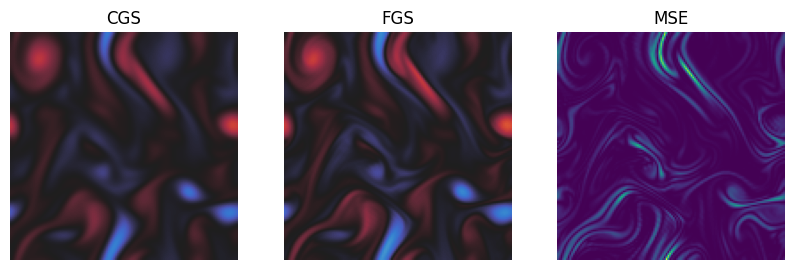

0.5778969078194154 -0.585238947598793
action = -0.7436325550079346; omega_cgs = 1.9667848737995859; omega2 = 1.996477709279388; rescaled action = 1.9667847928800315
0.9704695521380793


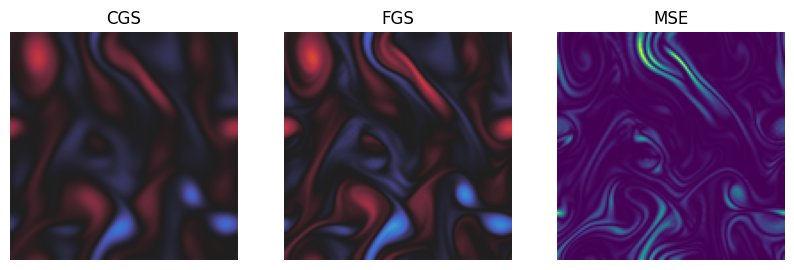

0.5304580375720654 -0.5484430847892575
#steps = 1013, Total Reward = 999.3596308815889


In [13]:
#play one episode and record statistics
reward = 0
step = 0
obs ,inf = env.reset()
policy.eval()
episode_is_over = False
#print(omg, env.unwrapped.fgs.omega, env.unwrapped.cgs.omega)
while not episode_is_over:

    action = policy(Batch(obs=np.array([obs]), info=inf)).act[0]
    obs, rew, terminated, truncated, inf = env.step(action.detach().cpu().numpy())
    #obs, rew, terminated, truncated, inf = env.step(-0.2)
    reward += rew
    step += 1
    if terminated or truncated:
        episode_is_over = True

    if step%500 == 0:
        ac = action.detach().cpu().numpy()[0]
        a = 0.98
        b = 1.02
        scaled_ac = a + 0.5*(b-a)*(ac+1)
        print(f"action = {ac}; omega_cgs = {env.unwrapped.cgs.omega}; omega2 = {env.unwrapped.fgs.omega}; rescaled action = {scaled_ac*env.unwrapped.fgs.omega}")
        env.render()

print(f"#steps = {step}, Total Reward = {reward}")
